# Early Experimentation

In [ ]:
import sys
import time
from IPython.display import clear_output

last_20 = []

line = "your message"
for i in range(10000):
    if i % 1 == 0:
        clear_output(wait=True)
        print(i)
    time.sleep(0.1)

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

m = 100
n = 100
matrix = np.random.normal(0,1,m*n).reshape(m,n)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100):
    time.sleep(0.1)
    ax.clear()
    ax.plot(matrix[i,:])
    fig.canvas.draw()

In [ ]:
%load_ext autoreload
%autoreload 2

print(np.random.randint(50))

# Query and visualize influx data

In [ ]:
import sys
!{sys.executable} -m pip install influxdb

In [ ]:
influx_db_private_ip = "172.31.41.46"
db = "telegraf-sm"

from influxdb import InfluxDBClient
client = InfluxDBClient(host=influx_db_private_ip, database=db)

In [ ]:
import datetime
def query():
    results = []
    result = client.query("SELECT * FROM \"mem\" WHERE \"user\" =~ /armand/ AND \"host\" =~ /algo-1/ ORDER BY time DESC LIMIT 100;")
    
    for r in result['mem']:
        t = datetime.datetime.strptime(r['time'], '%Y-%m-%dT%H:%M:%S.%fZ')
        pruned_r = {
            'time': t,
            'free': r['free'],
            'used': r['used']
        }
        results.append(pruned_r)
    return results

results = query()

In [ ]:
for r in results:
    print(r)

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import time



fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100_000_000):
    results = query()
#     print("query_complete")
    timestamps = [r['time'] for r in results]
    dependent_var = [r['free'] for r in results]
    time.sleep(0.1)
    ax.clear()
    ax.plot(timestamps, dependent_var)
    fig.canvas.draw()

# Logs

In [ ]:
import sys
import time
from IPython.display import clear_output, display

visible_lines = []
for i in range(1_000_000):
    if i % 100 == 0:
        
        clear_output()
        print(i)
    time.sleep(0.1)

In [ ]:
from collections import deque

d = deque([], maxlen=5)

for i in range(100):
    d.append(i)
    print(d)

In [ ]:
import boto3
import time

SM_CW_LOG_GROUP = "/aws/sagemaker/TrainingJobs"

region = "us-east-1"
sm_job = "armand-vgg-example-2019-06-24-22-12-16-025"
hostname = "algo-1"


def horovod_logline_handler(line):
    if 'errno' in line:
        pass
    else:
        # line = line.replace("#011", '\t')
        print(line)



def tail_sm_logs(sm_job_name, hostname, region="us-east-1", logline_hander=horovod_logline_handler):

    log_client = boto3.session.Session(region_name=region).client('logs')
    response = log_client.describe_log_streams(
        logGroupName=SM_CW_LOG_GROUP,
        logStreamNamePrefix=sm_job_name,
        orderBy='LogStreamName',
    )

    log_stream_prefix = f'{sm_job_name}/{hostname}-'
    log_stream_name = [s['logStreamName'] 
                       for s 
                       in response['logStreams'] 
                       if s['logStreamName'].startswith(log_stream_prefix)]

    assert len(log_stream_name) == 1, "There should only be one matching logstream"
    log_stream_name = log_stream_name[0]

    response = log_client.get_log_events(
        logGroupName=SM_CW_LOG_GROUP,
        logStreamName=log_stream_name,
        startFromHead=False
    )
    next_forward_token = response["nextForwardToken"]

    for log_event in response["events"]:
        logline_handler(log_event["message"])

    while True:
        response = log_client.get_log_events(
            logGroupName=SM_CW_LOG_GROUP,
            logStreamName=log_stream_name,
            nextToken=next_forward_token,
            startFromHead=False
        )

        for log_event in response["events"]:
            logline_handler(log_event["message"])

        # last_forward_token = next_forward_token
        next_forward_token = response["nextForwardToken"]
        time.sleep(0.5)



In [ ]:
import boto3
import time
from collections import deque
from IPython.display import clear_output, display

SM_CW_LOG_GROUP = "/aws/sagemaker/TrainingJobs"


def horovod_logline_handler(line):
    if 'errno' in line:
        pass
    else:
        # line = line.replace("#011", '\t')
        print(line)



def tail_sm_logs(sm_job_name, hostname, region="us-east-1", logline_handler=horovod_logline_handler):

    log_client = boto3.session.Session(region_name=region).client('logs')
    response = log_client.describe_log_streams(
        logGroupName=SM_CW_LOG_GROUP,
        logStreamNamePrefix=sm_job_name,
        orderBy='LogStreamName',
    )

    log_stream_prefix = f'{sm_job_name}/{hostname}-'
    log_stream_name = [s['logStreamName']
                       for s
                       in response['logStreams']
                       if s['logStreamName'].startswith(log_stream_prefix)]

    assert len(log_stream_name) == 1, "There should only be one matching logstream"
    log_stream_name = log_stream_name[0]

    response = log_client.get_log_events(
        logGroupName=SM_CW_LOG_GROUP,
        logStreamName=log_stream_name,
        startFromHead=False
    )
    next_forward_token = response["nextForwardToken"]

    for log_event in response["events"]:
        logline_handler(log_event["message"])

    while True:
        response = log_client.get_log_events(
            logGroupName=SM_CW_LOG_GROUP,
            logStreamName=log_stream_name,
            nextToken=next_forward_token,
            startFromHead=False
        )

        for log_event in response["events"]:
            logline_handler(log_event["message"])

        # last_forward_token = next_forward_token
        next_forward_token = response["nextForwardToken"]
        time.sleep(0.5)


class JupyterFixedMemoryLogger:
    def __init__(self):
        self.max_lines = 10
        self.pagination_overlap_lines = 1
        self.tail_buffer = deque([], maxlen=self.pagination_overlap_lines)
        self.output_length = 0

    def logline_handler(self, line):
        if 'errno' in line:
            return

        self.tail_buffer.append(line)
        self.output_length += 1
        print(line)

        if self.output_length == self.max_lines:
            clear_output()
            for l in self.tail_buffer:
                print(l)
                
            self.tail_buffer.clear()
            self.output_length = self.pagination_overlap_lines

jlogger = JupyterFixedMemoryLogger()

In [ ]:
region = "us-east-1"
sm_job = "armand-vgg-example-2019-06-24-22-12-16-025"
hostname = "algo-1"

tail_sm_logs(sm_job, hostname, region=region, logline_handler=jlogger.logline_handler)

In [ ]:
Javascript(
    """$.getScript('https://cdnjs.cloudflare.com/ajax/libs/jquery/3.4.1/jquery.min.js')"""
)

In [ ]:
%%html
<div id="log_tailer" height="800"></div>

In [ ]:
%%javascript

// https://nbviewer.jupyter.org/github/ipython/ipython/blob/master/examples/IPython%20Kernel/Rich%20Output.ipynb

// element is the jQuery element we will append to
var e = element.get(0);

$( "#log_tailer" ).html( "<div>2</div><div>3</div><div>4</div>" )



# GPU view

In [ ]:
!pip install --user nbmultitask
!pip install --user hvplot
!pip install --user bokeh
!pip install --user holoviews


In [ ]:
from influxdb import InfluxDBClient
influx_db_private_ip = "172.31.41.46"

def get_gpu_util():
    query_str = "SELECT mean(\"utilization_gpu\") FROM \"nvidia_smi\" WHERE \"cluster\" =~ /hackathon-vgg-sagemaker-2node/  AND time > now()-1s GROUP BY time(2s), \"host\", \"index\" fill(null);"

    client = InfluxDBClient(host=influx_db_private_ip, database="telegraf-sm")
    gpu_util_query_response = client.query(query_str)

    results = {}
    for host in ['algo-1', 'algo-2']:
        results[host] = {}
        for gpu_index in range(8):
            datapoint = list(gpu_util_query_response.get_points(measurement='nvidia_smi', 
                                                                tags={"host": host, 
                                                                      "index": f'{gpu_index}'}))
            if len(datapoint) != 0:
                v = datapoint[-1]['mean']
            else:
                v = 0
            results[host][gpu_index] = v

    return results


In [ ]:
import numpy as np
import holoviews as hv
from holoviews import opts
import pandas as pd
hv.extension('bokeh')



coords = [(0,0),
          (1,0),
          (2,0),
          (3,0),
          (0,1),
          (1,1),
          (2,1),
          (3,1),
         ]

def get_gpu_data():
    plottable_data = {}
    for host in ['algo-1', 'algo-2']:
        plottable_data[host] = []
        for gpu_index in range(8):
            v = get_gpu_util()[host][gpu_index]
            x,y = coords[gpu_index]

            plottable_data[host].append(f'{x},{y},{v}')

    df = pd.DataFrame(data=plottable_data)
    return df




In [ ]:
from tornado.ioloop import PeriodicCallback

def clean(host_data):
    clean_host_data = []
    for r in host_data:
        x = int(r[0])
        y = int(r[1])
        v = r[2]
        if r[2] is None or r[2] == 'None':
            v = 0
        else:
            v=float(v)
        
        clean_host_data.append((x,y,v))
    return clean_host_data


def gpu_util():
    import datetime as dt

    import psutil
    import pandas as pd
    import holoviews as hv
    from holoviews import dim, opts

    renderer = hv.renderer('bokeh')

  


    # Define DynamicMap callbacks returning Elements

    def gpu_map(data):
        data_algo1 = [d.split(",") for d in data['algo-1']]
        data_algo2 = [d.split(",") for d in data['algo-2']]
        
        data_algo1 = clean(data_algo1)
        data_algo2 = clean(data_algo2)
        
        algo1_map = hv.HeatMap(data_algo1).options(cmap='coolwarm', 
                                               title="GPU Heatmap (algo1)",
                                               width=400,
                                                  colorbar=True).sort()
        algo2_map = hv.HeatMap(data_algo2).options(cmap='coolwarm', 
                                               title="GPU Heatmap (algo2)",
                                               width=400,
                                                  colorbar=True).sort()

        full_plot = algo1_map + algo2_map.opts(shared_axes=False)
        return full_plot





    gpu_stream = hv.streams.Buffer(get_gpu_data())


    def cb():
        gpu_stream.send(get_gpu_data())


    # Define DynamicMaps and display plot

    gpu_dmap = hv.DynamicMap(gpu_map, streams=[gpu_stream])


    # Render plot and attach periodic callback
    cb_attacher = PeriodicCallback(cb, 100)
    cb_attacher.start()
    return gpu_dmap, cb_attacher

In [ ]:
gpu_dmap, cb = gpu_util()
gpu_dmap

In [ ]:
cb.stop()

# Network Graphing

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
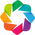

:Curve   [timestamps]   (download_rate)

In [33]:

import numpy as np
import holoviews as hv
from holoviews import opts
import pandas as pd
hv.extension('bokeh')
from influxdb import InfluxDBClient
influx_db_private_ip = "172.31.41.46"

def bits_to_gbits(bits):
    return bits/1024/1024/1024

def query_network_util():
    query_str = "SELECT derivative(bytes_recv, 1s)*8 as \"download_rate\" FROM net WHERE \"user\" =~ /armand/ AND \"host\" =~ /algo-1/ AND \"interface\" = 'eth0' AND time > now()-5s;"

    client = InfluxDBClient(host=influx_db_private_ip, database="telegraf-sm")
    network_util_query_response = client.query(query_str)


    results = []
    for p in network_util_query_response.get_points():
        results.append((p['time'], bits_to_gbits(p['download_rate'])))

    return results





def get_network_data_dict_of_lists():
    network_timeseries = query_network_util()
    timestamps = [pd.Timestamp(d[0]) for d in network_timeseries]
    rates = [d[1] for d in network_timeseries]
    
    df = pd.DataFrame(data={'timestamps': timestamps, 'download_rate': rates})
    return df


def get_network_data_list_of_tuples():
    
    network_timeseries = query_network_util()
    network_timeseries = [ ( pd.Timestamp(d[0]), d[1] ) for d in network_timeseries]
    
    df = pd.DataFrame(data=network_timeseries)
    return df

def get_network_data_list_of_dicts():
    network_timeseries = query_network_util()
    network_timeseries = [ {'timestamp': pd.Timestamp(d[0]), 'download_rate': d[1] } for d in network_timeseries]    
    df = pd.DataFrame(data=network_timeseries)
    return df

def get_network_data():
#     return get_network_data_list_of_tuples()
#     return get_network_data_list_of_dicts()
    return get_network_data_dict_of_lists()
    
net = get_network_data()
hv.Curve(net)




In [43]:
from tornado.ioloop import PeriodicCallback

def network_util_graph():
    import datetime as dt

    import psutil
    import pandas as pd
    import holoviews as hv
    from holoviews import dim, opts

    renderer = hv.renderer('bokeh')

  


    # Define DynamicMap callbacks returning Elements

    def network_map(data):
#         start = data['timestamps'][0]
#         end = data['timestamps'][-1]
#         plot = hv.Curve(data).options(title="Network utilization (algo1)", width=800, xlim=(start, end))
#         return plot

        plot = hv.Curve(data).options(title="Network utilization (algo1)", width=800, padding=0.1)
        return plot
        
 





    network_stream = hv.streams.Buffer(get_network_data(), length=500, index=False)


    def cb():
        network_stream.send(get_network_data())


    # Define DynamicMaps and display plot

    network_dmap = hv.DynamicMap(network_map, streams=[network_stream])


    # Render plot and attach periodic callback
    cb_attacher = PeriodicCallback(cb, 100)
    cb_attacher.start()
    return network_dmap, cb_attacher



In [44]:
network_graph, cb = network_util_graph()
network_graph

:DynamicMap   []
   :Curve   [timestamps]   (download_rate)

In [45]:
cb.stop()

<IPython.core.display.Javascript object>


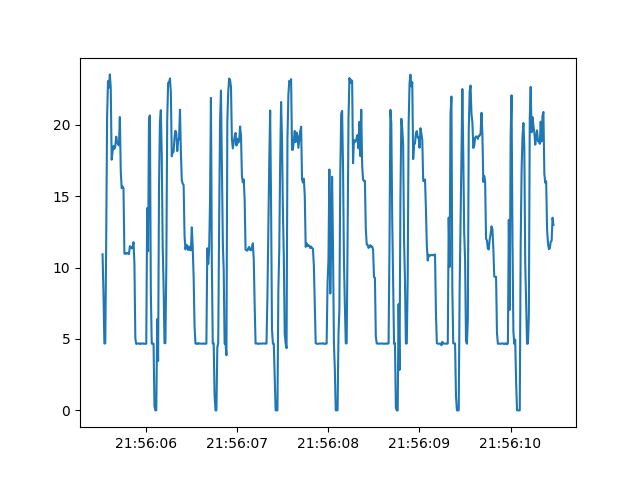

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import time



fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100_000_000):
    results = get_network_data()
#     print("query_complete")
    timestamps = results['timestamps']
    dependent_var = results['download_rate']
    time.sleep(0.1)
    ax.clear()
    ax.plot(timestamps, dependent_var)
    fig.canvas.draw()